Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import joblib
import shap
from pathlib import Path

# Settings
sns.set_style("whitegrid")
shap.initjs()
print("All libraries imported successfully!")

✅ All libraries imported successfully!


Load the Model

In [ ]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent

model_dir = PROJECT_ROOT / "models"
model_path = model_dir / "xgb_fake_job_model.pkl"
vectorizer_path = model_dir / "tfidf_vectorizer.pkl"

model = joblib.load(model_path)
vectorizer = joblib.load(vectorizer_path)

print(f"Model loaded from: {model_path}")
print(f"Vectorizer loaded from: {vectorizer_path}")

data_path = PROJECT_ROOT / "data" / "cleaned_fake_job_postings.csv"
df = pd.read_csv(data_path)

print(f"\nData loaded from: {data_path}")
print(f"Dataset shape: {df.shape}")
df.head()

✅ Model loaded from: d:\fake-job-detector-using-nlp\models\xgb_fake_job_model.pkl
✅ Vectorizer loaded from: d:\fake-job-detector-using-nlp\models\tfidf_vectorizer.pkl

✅ Data loaded from: d:\fake-job-detector-using-nlp\data\cleaned_fake_job_postings.csv
Dataset shape: (17880, 2)


,clean_text,fraudulent
0,marketing intern marketing food fast growing j...,0
1,customer service cloud video production succes...,0
2,commissioning machinery assistant cma client l...,0
3,account executive washington sale company esri...,0
4,bill review manager job title itemization revi...,0


Prepare Test Data

In [ ]:
print("Preparing test data...")

X = vectorizer.transform(df['clean_text'])
y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print(f"Test set prepared")
print(f"Test samples: {X_test.shape[0]}")
print(f"Predictions generated")

Preparing test data...
✅ Test set prepared
Test samples: 3576
Predictions generated


Report 

In [ ]:
print("="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

report_dict = classification_report(y_test, y_pred, target_names=['Real', 'Fake'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nClassification report generated")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      3403
        Fake       0.81      0.69      0.75       173

    accuracy                           0.98      3576
   macro avg       0.89      0.84      0.87      3576
weighted avg       0.98      0.98      0.98      3576


✅ Classification report generated


Confusion Matrix

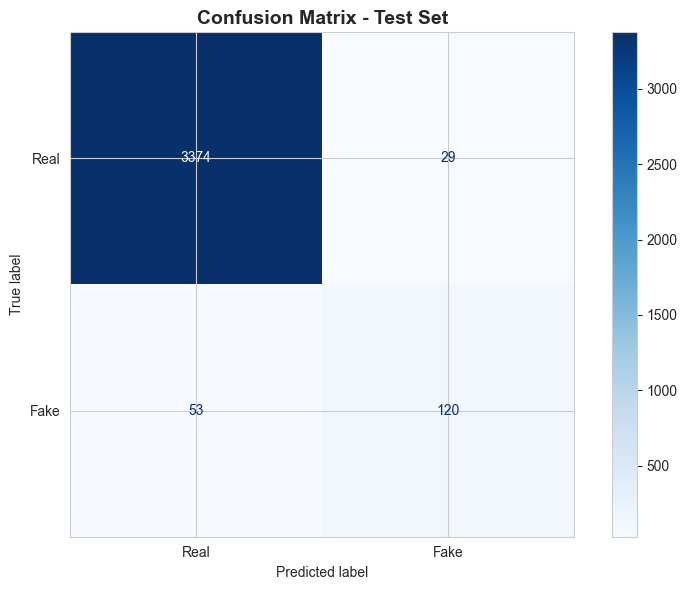


Confusion Matrix Breakdown:
True Negatives (Real → Real): 3374
False Positives (Real → Fake): 29
False Negatives (Fake → Real): 53
True Positives (Fake → Fake): 120


In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix - Test Set", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Real → Real): {tn}")
print(f"False Positives (Real → Fake): {fp}")
print(f"False Negatives (Fake → Real): {fn}")
print(f"True Positives (Fake → Fake): {tp}")

Feature Importance Analysis

TOP 20 PREDICTIVE FEATURES
 1. data entry           → 0.033347
 2. oil                  → 0.025587
 3. home                 → 0.018434
 4. experience required  → 0.016045
 5. income               → 0.015529
 6. solve                → 0.014301
 7. professional manner  → 0.012248
 8. within               → 0.011891
 9. hr                   → 0.011267
10. duty                 → 0.011228
11. per day              → 0.010356
12. part time            → 0.010348
13. operation            → 0.010266
14. phone                → 0.009839
15. grade                → 0.008531
16. schedule             → 0.007719
17. rep                  → 0.007597
18. work life            → 0.007525
19. computer science     → 0.007512
20. pay                  → 0.007466


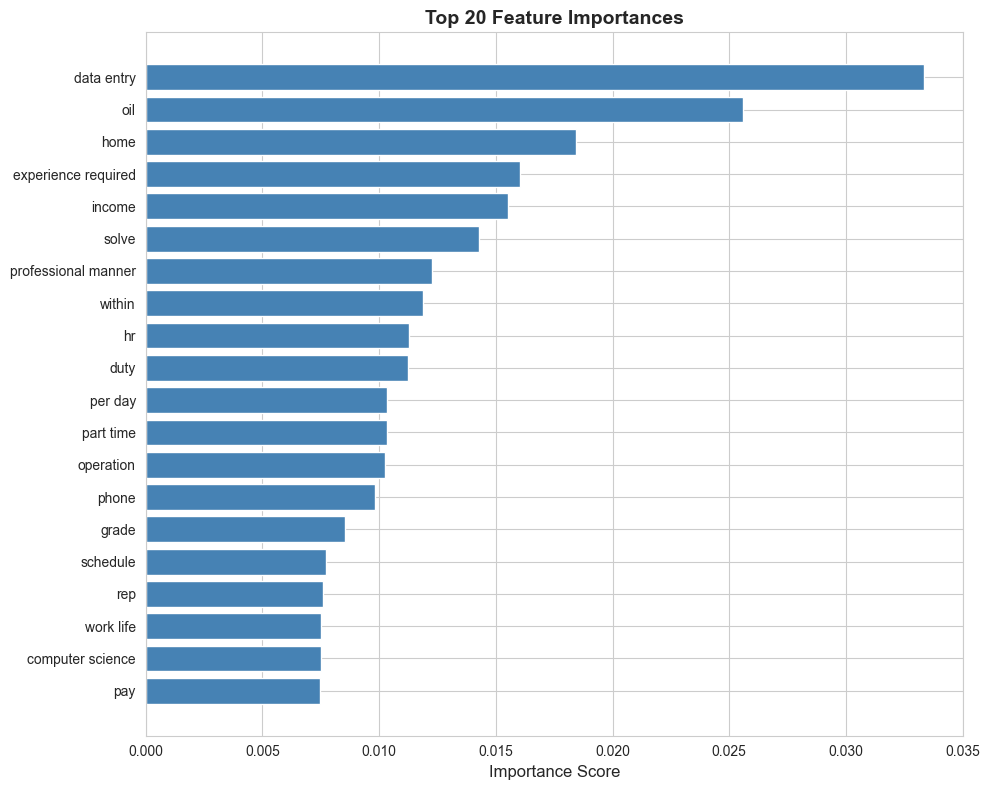

In [ ]:
print("="*60)
print("TOP 20 PREDICTIVE FEATURES")
print("="*60)

features = vectorizer.get_feature_names_out()
importances = model.feature_importances_
top_n = 20
top_idx = np.argsort(importances)[-top_n:][::-1]

for rank, idx in enumerate(top_idx, 1):
    print(f"{rank:2d}. {features[idx]:20s} → {importances[idx]:.6f}")

fig, ax = plt.subplots(figsize=(10, 8))
feature_names = [features[i] for i in top_idx]
feature_importances = [importances[i] for i in top_idx]

ax.barh(range(len(feature_names)), feature_importances, color='steelblue')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

SHAP Analysis Fake Job


SHAP EXPLANATION - FAKE JOB EXAMPLE
Input text: Earn $5000/week from home! No experience needed. Apply now and start earning today!
Prediction: REAL
Confidence: 85.78%

Computing SHAP values...

Generating SHAP waterfall plot...


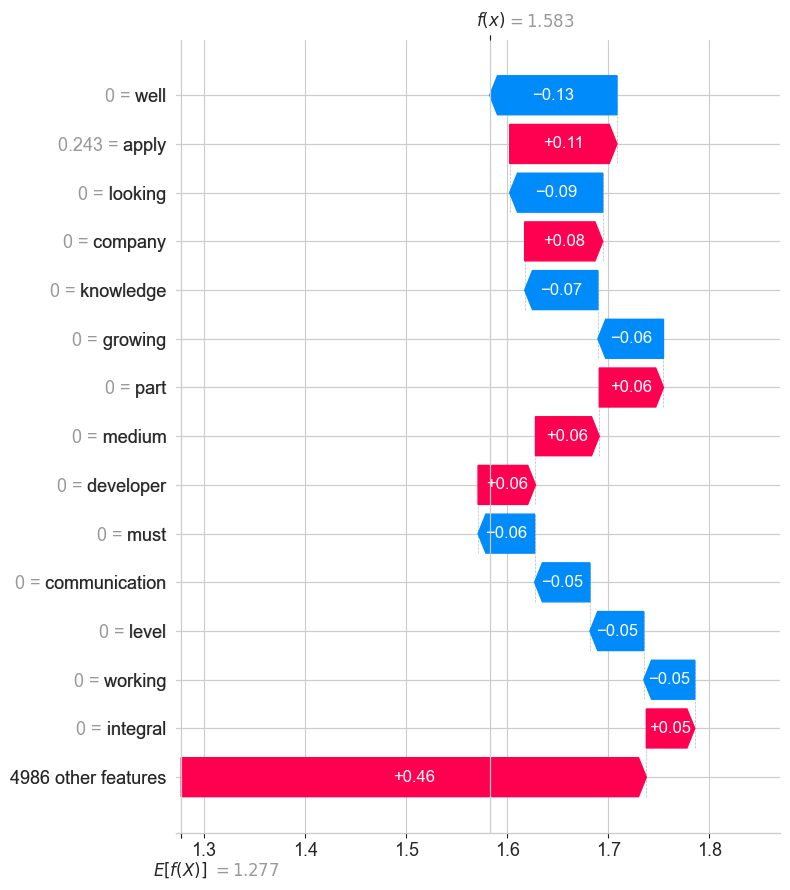

In [ ]:
print("\n" + "="*60)
print("SHAP EXPLANATION - FAKE JOB EXAMPLE")
print("="*60)

fake_example = ["Earn $5000/week from home! No experience needed. Apply now and start earning today!"]
print(f"Input text: {fake_example[0]}")

fake_vec = vectorizer.transform(fake_example)
fake_pred = model.predict(fake_vec)[0]
fake_proba = model.predict_proba(fake_vec)[0]

print(f"Prediction: {'FAKE' if fake_pred == 1 else 'REAL'}")
print(f"Confidence: {fake_proba[fake_pred]*100:.2f}%")

fake_vec_dense = fake_vec.toarray()

print("\nComputing SHAP values...")
background_sample = X_train[:100].toarray()  
explainer = shap.TreeExplainer(model, background_sample)
shap_values_fake = explainer.shap_values(fake_vec_dense)

shap_explanation = shap.Explanation(
    values=shap_values_fake[0],
    base_values=explainer.expected_value,
    data=fake_vec_dense[0],
    feature_names=features.tolist()
)

print("\nGenerating SHAP waterfall plot...")
fig, ax = plt.subplots(figsize=(10, 8))
shap.plots.waterfall(shap_explanation, max_display=15, show=False)
plt.tight_layout()
plt.show()

SHAP Analysis Real Job


SHAP EXPLANATION - REAL JOB EXAMPLE
Input text: Software Engineer position at tech company. Required: 3+ years Python experience, bachelor's degree ...
Prediction: REAL
Confidence: 93.01%

Computing SHAP values...

Generating SHAP waterfall plot...


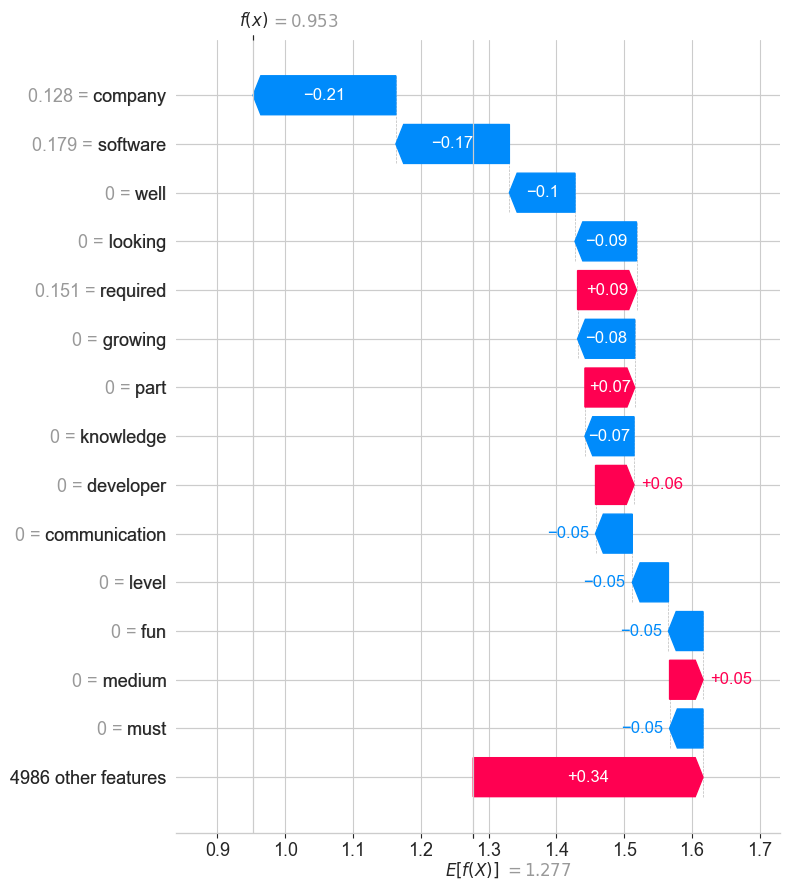

In [ ]:
print("\n" + "="*60)
print("SHAP EXPLANATION - REAL JOB EXAMPLE")
print("="*60)

real_example = ["Software Engineer position at tech company. Required: 3+ years Python experience, bachelor's degree in CS. Responsibilities include developing scalable applications."]
print(f"Input text: {real_example[0][:100]}...")

real_vec = vectorizer.transform(real_example)
real_pred = model.predict(real_vec)[0]
real_proba = model.predict_proba(real_vec)[0]

print(f"Prediction: {'FAKE' if real_pred == 1 else 'REAL'}")
print(f"Confidence: {real_proba[real_pred]*100:.2f}%")

real_vec_dense = real_vec.toarray()

print("\nComputing SHAP values...")
shap_values_real = explainer.shap_values(real_vec_dense)

shap_explanation_real = shap.Explanation(
    values=shap_values_real[0],
    base_values=explainer.expected_value,
    data=real_vec_dense[0],
    feature_names=features.tolist()
)

print("\nGenerating SHAP waterfall plot...")
fig, ax = plt.subplots(figsize=(10, 8))
shap.plots.waterfall(shap_explanation_real, max_display=15, show=False)
plt.tight_layout()
plt.show()

SHAP Summary Plot


SHAP SUMMARY - MULTIPLE TEST SAMPLES
Computing SHAP values for 50 test samples...
This may take a minute...

Generating SHAP summary plot...


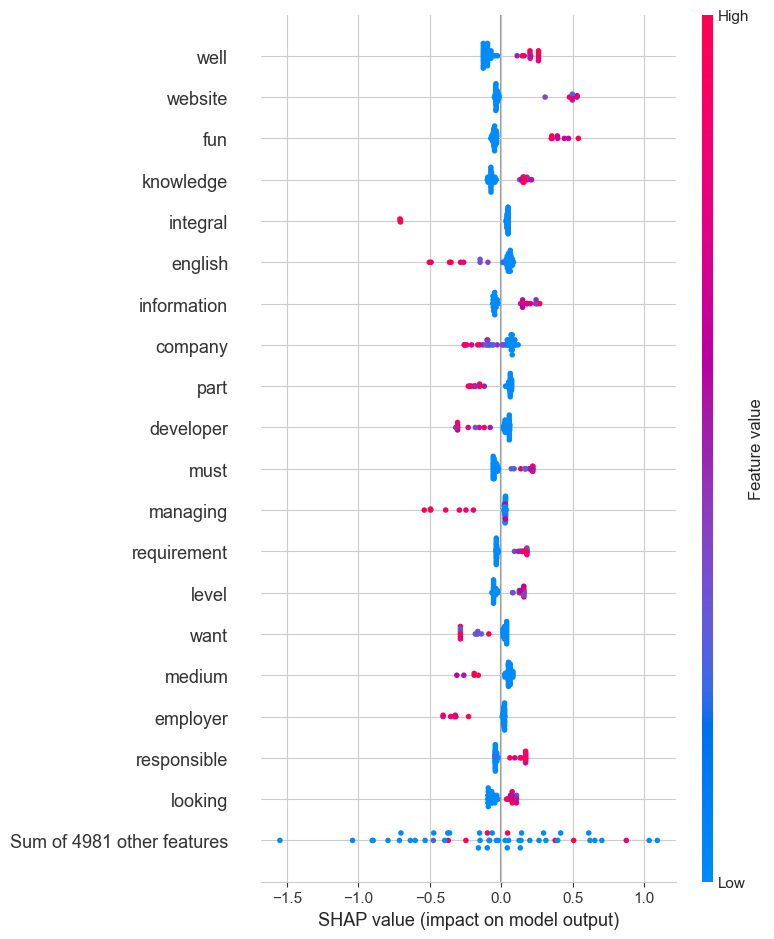


Generating SHAP bar plot...


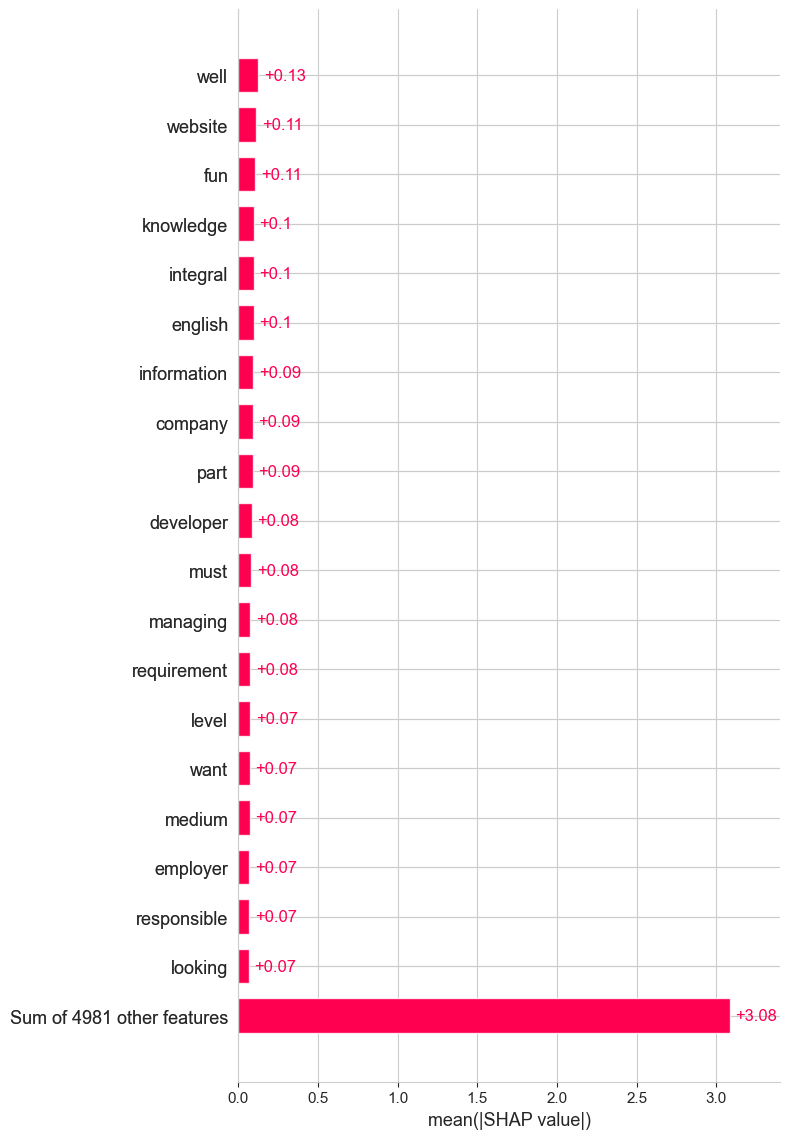

In [ ]:
print("\n" + "="*60)
print("SHAP SUMMARY - MULTIPLE TEST SAMPLES")
print("="*60)

sample_size = min(50, X_test.shape[0])
X_sample_dense = X_test[:sample_size].toarray()

print(f"Computing SHAP values for {sample_size} test samples...")
print("This may take a minute...")

shap_values_sample = explainer.shap_values(X_sample_dense)

shap_explanation_summary = shap.Explanation(
    values=shap_values_sample,
    base_values=np.array([explainer.expected_value] * sample_size),
    data=X_sample_dense,
    feature_names=features.tolist()
)

print("\nGenerating SHAP summary plot...")
fig, ax = plt.subplots(figsize=(10, 8))
shap.plots.beeswarm(shap_explanation_summary, max_display=20, show=False)
plt.tight_layout()
plt.show()

print("\nGenerating SHAP bar plot...")
fig, ax = plt.subplots(figsize=(10, 8))
shap.plots.bar(shap_explanation_summary, max_display=20, show=False)
plt.tight_layout()
plt.show()

Error Analysis

In [ ]:
print("\n" + "="*60)
print("ERROR ANALYSIS - MISCLASSIFIED POSTS")
print("="*60)

test_df = df.iloc[y_test.index].copy()
test_df['predicted'] = y_pred
test_df['confidence'] = y_pred_proba.max(axis=1)
test_df['correct'] = test_df['fraudulent'] == test_df['predicted']

false_positives = test_df[(test_df['fraudulent'] == 0) & (test_df['predicted'] == 1)]
print(f"\nFalse Positives (Real → Fake): {len(false_positives)}")
if len(false_positives) > 0:
    print("\nTop 3 False Positives (high confidence errors):")
    for idx, row in false_positives.nlargest(3, 'confidence').iterrows():
        print(f"\n  Text: {row['clean_text'][:100]}...")
        print(f"  Confidence: {row['confidence']*100:.2f}%")

false_negatives = test_df[(test_df['fraudulent'] == 1) & (test_df['predicted'] == 0)]
print(f"\nFalse Negatives (Fake → Real): {len(false_negatives)}")
if len(false_negatives) > 0:
    print("\nTop 3 False Negatives (high confidence errors):")
    for idx, row in false_negatives.nlargest(3, 'confidence').iterrows():
        print(f"\n  Text: {row['clean_text'][:100]}...")
        print(f"  Confidence: {row['confidence']*100:.2f}%")


ERROR ANALYSIS - MISCLASSIFIED POSTS

False Positives (Real → Fake): 29

Top 3 False Positives (high confidence errors):

  Text: housing counselor community training center basic job function nbsp nbsp nbsp nbsp nbsp nbsp nbsp nb...
  Confidence: 95.45%

  Text: part time administrative data entry part time administrative assistant data entry responsible report...
  Confidence: 86.95%

  Text: customer service rep video game small dot com start based maryland height missouri seeking customer ...
  Confidence: 84.06%

False Negatives (Fake → Real): 53

Top 3 False Negatives (high confidence errors):

  Text: business development manager sale currently looking client focused result driven business developmen...
  Confidence: 98.17%

  Text: sale associate home security sale sale inside outside data compilation prospective sale lead lead us...
  Confidence: 96.97%

  Text: assistant accountant looking assistant accountant join professional highly regarded company suitable...
  Confidenc

Save Results and Reports

In [ ]:
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

results_dir = PROJECT_ROOT / "results"
results_dir.mkdir(parents=True, exist_ok=True)

report_path = results_dir / "classification_report.csv"
report_df.to_csv(report_path)
print(f"Classification report saved: {report_path}")

cm_path = results_dir / "confusion_matrix.png"
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix - Test Set", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Confusion matrix saved: {cm_path}")

fi_path = results_dir / "feature_importance.png"
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(feature_names)), feature_importances, color='steelblue')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(fi_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Feature importance saved: {fi_path}")

fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})
fi_csv_path = results_dir / "feature_importance.csv"
fi_df.to_csv(fi_csv_path, index=False)
print(f"Feature importance data saved: {fi_csv_path}")

error_path = results_dir / "error_analysis.csv"
error_df = test_df[['clean_text', 'fraudulent', 'predicted', 'confidence', 'correct']]
error_df.to_csv(error_path, index=False)
print(f"Error analysis saved: {error_path}")

print("\n" + "="*60)
print("EXPLAINABILITY ANALYSIS COMPLETE!")
print("="*60)
print(f"   - Results saved in: {results_dir}")
print(f"   - Files created:")
print(f"   - classification_report.csv")
print(f"   - confusion_matrix.png")
print(f"   - feature_importance.png")
print(f"   - feature_importance.csv")
print(f"   - error_analysis.csv")
print("="*60)


SAVING RESULTS
✅ Classification report saved: d:\fake-job-detector-using-nlp\results\classification_report.csv
✅ Confusion matrix saved: d:\fake-job-detector-using-nlp\results\confusion_matrix.png
✅ Feature importance saved: d:\fake-job-detector-using-nlp\results\feature_importance.png
✅ Feature importance data saved: d:\fake-job-detector-using-nlp\results\feature_importance.csv
✅ Error analysis saved: d:\fake-job-detector-using-nlp\results\error_analysis.csv

EXPLAINABILITY ANALYSIS COMPLETE!
📁 Results saved in: d:\fake-job-detector-using-nlp\results
📊 Files created:
   - classification_report.csv
   - confusion_matrix.png
   - feature_importance.png
   - feature_importance.csv
   - error_analysis.csv
